# Analysis of [Avocado Sales 2015/21 in U.S.](https://www.kaggle.com/datasets/valentinjoseph/avocado-sales-20152021-us-centric) by **Kacper Piątkowski**

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import calendar

months = [month for month in list(calendar.month_name)][1:]
split_on = 1000

avocado_df = pd.read_csv('avocado_cleaned.csv')

In [100]:
avocado_df.head()

,Date,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,1/4/2015,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,1/4/2015,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,1/11/2015,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
3,1/11/2015,1.77,1182.56,39.00,305.12,0.00,838.44,838.44,0.00,0.0,organic,2015,Albany
4,1/18/2015,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany


# Note:
    1) Date - date of the observation
    2) AveragePrice - average price of a single avocado
    3) TotalVolume - Total number of avocados sold
    4) plu4046 - Total number of avocados with PLU 4046 sold (non oragnic small.medium Hass Avocados ~3-5oz)
    5) plu4225 - Total number of avocados with PLU 4225 sold (non-organic large Hass Avocados ~8-10 oz)
    6) plu4770 - Total number of avocados with PLU 4770 sold (non-organic extra large Hass Avocados ~10-15 oz)

In [101]:
avocado_df['type'] = avocado_df['type'].apply(lambda x: x.lower())
avocado_df['Date'] = pd.to_datetime(avocado_df['Date'], infer_datetime_format=True)
avocado_df = avocado_df.drop(columns=['year', 'region'])

print('Types of avocados:', *avocado_df.type.unique())
avocado_df.head()

Types of avocados: conventional organic


,Date,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags,type
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic
2,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional
3,2015-01-11,1.77,1182.56,39.00,305.12,0.00,838.44,838.44,0.00,0.0,organic
4,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional


# Note:
    I've cleaned up the data, dropped the columns I won't be using and changed the date to be pandas format.

Conventional amount sold:  3.42e+10
Organic amount sold:  1.24e+09
There were 27.586 times more conventional avocados sold than organic


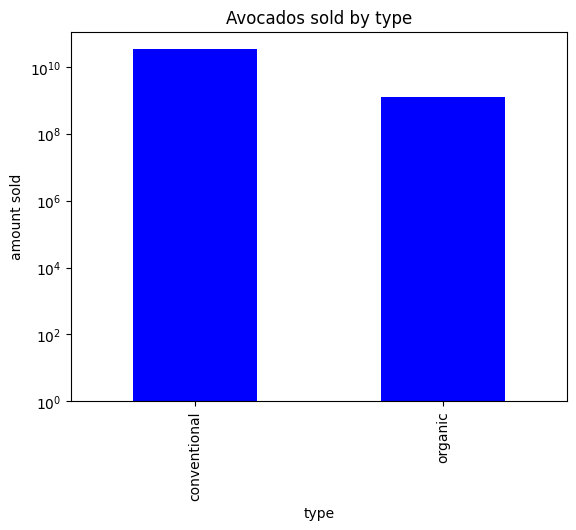

In [102]:
types_volume = avocado_df.groupby(['type'])['TotalVolume'].sum()

print('Conventional amount sold: ', "{:.2e}".format(types_volume['conventional']))
print('Organic amount sold: ', "{:.2e}".format(types_volume['organic']))
print('There were', "{:.3f}".format(types_volume['conventional']/types_volume['organic']), 'times more conventional avocados sold than organic')

types_volume.plot(kind='bar', log=True, ylabel='amount sold', title='Avocados sold by type', color='b')
plt.show()

# Note:
    First of all I wanted to see how the type of an avocado affected the amount sold. As we can see there were 27.5 times more conventional avocado's sold than the organic ones.

Conventional average price: 1.16
Organic average price: 1.69
Organic avocados were 0.53 (37.0%) more expensive on average than the conventional ones


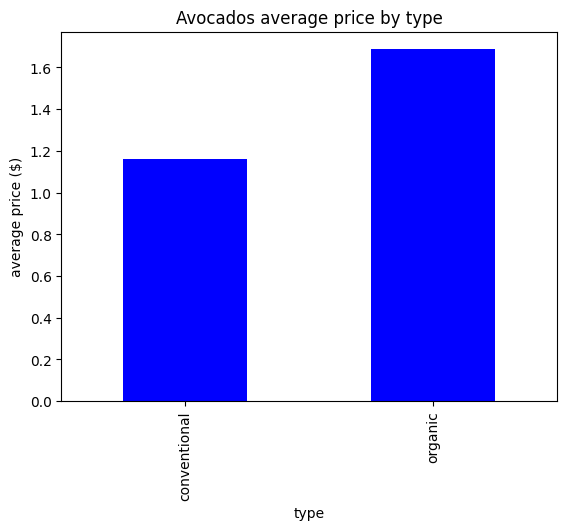

In [103]:
types_average_price = avocado_df.groupby(['type'])['AveragePrice'].mean()
conv_price, org_price = types_average_price['conventional'], types_average_price['organic']

print(f'Conventional average price: {conv_price:.2f}')
print(f'Organic average price: {org_price:.2f}')
difference = abs(conv_price - org_price)
percentage = difference / ((conv_price + org_price) / 2) * 100
print(f'Organic avocados were {difference:.2f} ({percentage:.1f}%) more expensive on average than the conventional ones')

types_average_price.plot(kind='bar', ylabel='average price ($)', title='Avocados average price by type', color='b')
plt.show()

# Note:
    Next up I've checked the price difference on average between those 2 types.
    I was expecting a difference between the two, but it was bigger than I anticipated as it was 53 cent (so about 37%) difference.

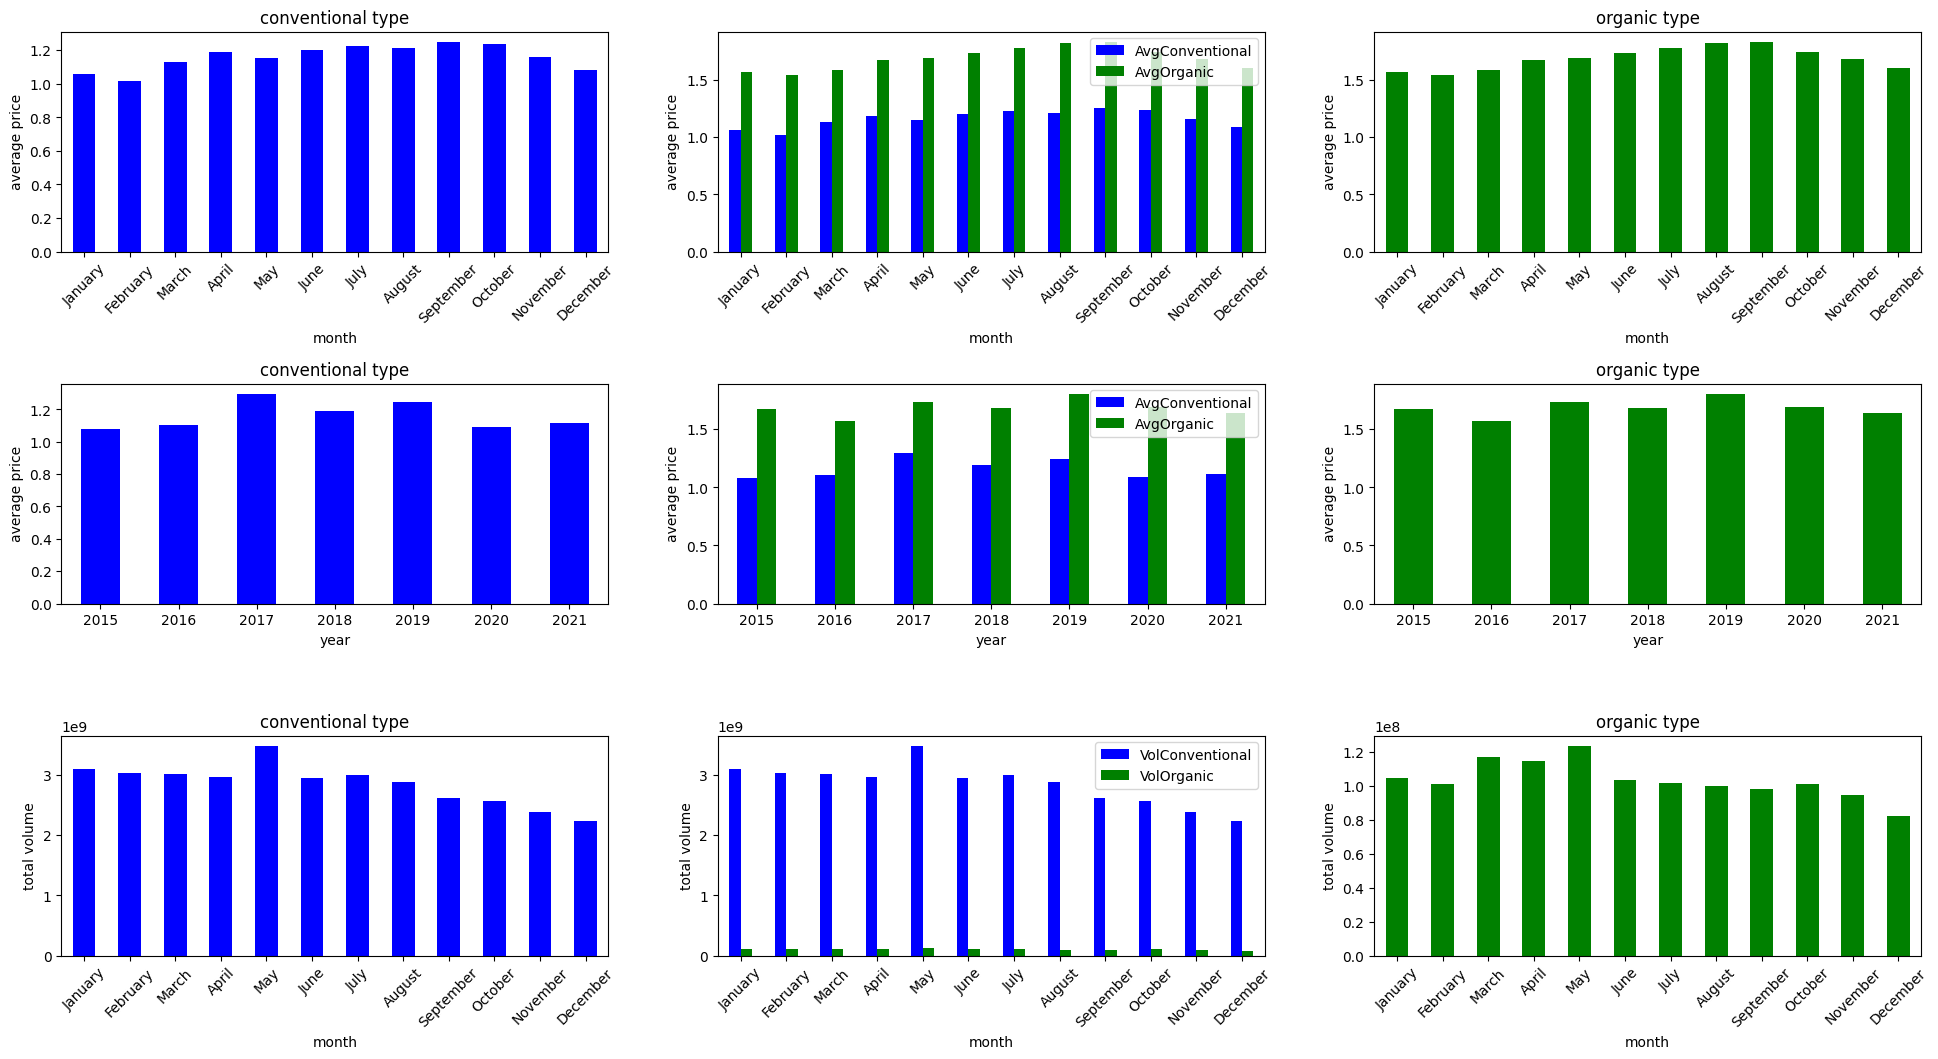

In [104]:
monthly = avocado_df.groupby([(avocado_df.Date.dt.month)]).sum(numeric_only=True)
yearly = avocado_df.groupby([(avocado_df.Date.dt.year)]).sum(numeric_only=True)

# avocado dataframe based on type
conventional = avocado_df.loc[avocado_df.type == 'conventional']
organic = avocado_df.loc[avocado_df.type == 'organic']

# group by month
monthly_conv_group = conventional.groupby(conventional["Date"].dt.month)["AveragePrice"].mean(numeric_only=True)
monthly_org_group = organic.groupby(organic["Date"].dt.month)["AveragePrice"].mean(numeric_only=True)
monthly_conv_group.index, monthly_org_group.index = months, months
monthly_group = monthly_conv_group.to_frame(name='AvgConventional').join(monthly_org_group.to_frame(name='AvgOrganic'))

# group by year
yearly_conv_group = conventional.groupby(conventional["Date"].dt.year)["AveragePrice"].mean(numeric_only=True)
yearly_org_group = organic.groupby(organic["Date"].dt.year)["AveragePrice"].mean(numeric_only=True)
yearly_group = yearly_conv_group.to_frame(name='AvgConventional').join(yearly_org_group.to_frame(name='AvgOrganic'))

# plot settings
fig, axs = plt.subplots(3, 3, figsize=(24, 12))
plt.subplots_adjust(hspace=0.6)

# plot monthly
monthly_conv_group.plot(kind='bar', rot=45, ax=axs[0, 0], color='b', xlabel='month', ylabel='average price', title='conventional type')
monthly_group.plot(kind='bar', rot=45, ax=axs[0, 1], color=['b', 'g'], xlabel='month', ylabel='average price')
monthly_org_group.plot(kind='bar', rot=45, ax=axs[0, 2], color='g', xlabel='month', ylabel='average price', title='organic type')

# plot yearly
yearly_conv_group.plot(kind='bar', rot=0, ax=axs[1, 0], color='b', xlabel='year', ylabel='average price', title='conventional type')
yearly_group.plot(kind='bar', rot=0, ax=axs[1, 1], color=['b', 'g'], xlabel='year', ylabel='average price')
yearly_org_group.plot(kind='bar', rot=0, ax=axs[1, 2], color='g', xlabel='year', ylabel='average price', title='organic type')

# group by month
monthly_conv_group_vol = conventional.groupby(conventional["Date"].dt.month)["TotalVolume"].sum(numeric_only=True)
monthly_org_group_vol = organic.groupby(organic["Date"].dt.month)["TotalVolume"].sum(numeric_only=True)
monthly_conv_group_vol.index, monthly_org_group_vol.index = months, months
monthly_group_vol = monthly_conv_group_vol.to_frame(name='VolConventional').join(monthly_org_group_vol.to_frame(name='VolOrganic'))

# plot monthly
monthly_conv_group_vol.plot(kind='bar', rot=45, ax=axs[2, 0], color='b', xlabel='month', ylabel='total volume', title='conventional type')
monthly_group_vol.plot(kind='bar', rot=45, ax=axs[2, 1], color=['b', 'g'], xlabel='month', ylabel='total volume')
monthly_org_group_vol.plot(kind='bar', rot=45, ax=axs[2, 2], color='g', xlabel='month', ylabel='total volume', title='organic type')

plt.show()

# Note:
1) Since I grouped the avocados based on the type previously I thought it'll be a good idea to keep on analyzing the differences between the two types in the dataset.
2) I've grouped the data based on the month of the sales and the year of the sales to have a better understanding of the dataset.
3) I've tried searching the price-volume dependency.

#### Monthly:
- When we look at the month based charts on the top we see that the prices of the conventional type of avocados are rather stable and peak at September and October, although we do not see a clear pattern - the prices increase in one month and then they drop.
- Organic avocados on the other hand have a very smooth price curve. The prices for them grow every month until they hit the peak price in September and then they stabilize to the price from the beginning of the year 
- The most conventional type avocados are sold in May. May is also a month in which the price of avocados begins to increase.
- The best months for selling the organic avocados were March, April and May.

#### Yearly:
- When it comes to conventional type of avocados the price peaked in the year 2017 which was a significant change looking at the previous year. We should anticipate a slight increase the prices in the year 2022.
- In the organic type of avocados the pattern is rather odd (if you even want to call it a some type of pattern). Initially we see a slight decrease in price and next year came with a price increase. It keeps the decreasing-increasing trend until in the 2021 it breaks, but I think we should anticipate the organic avocados price increase (and when it comes maybe even a peak price).  

Mean squared error equals: 0.07694
Square root of the mean squared error equals: 0.27738
Model score: 0.38516


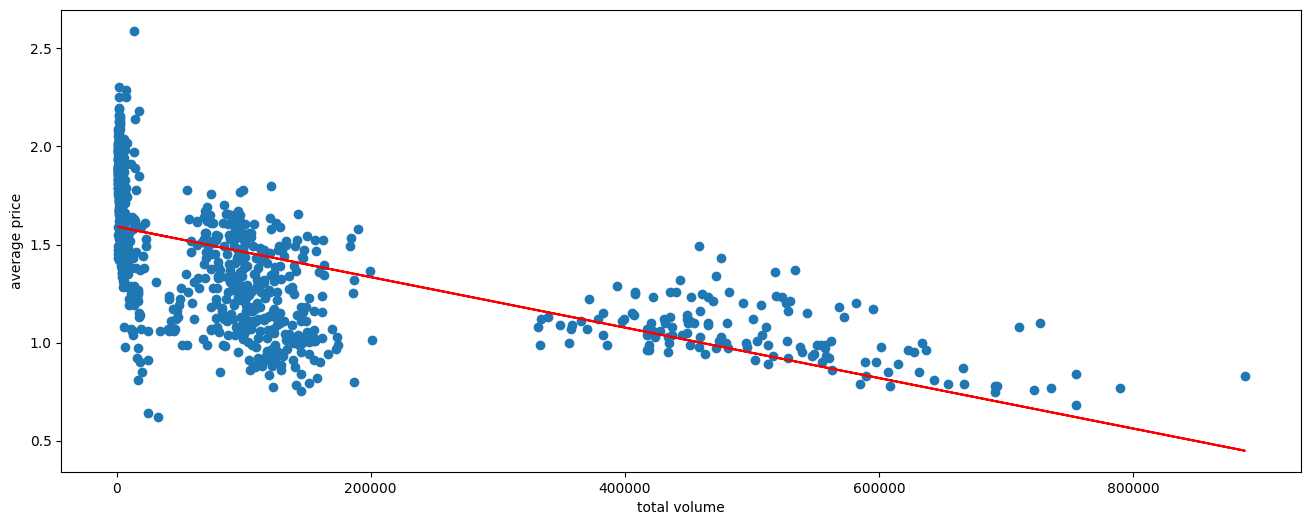

In [105]:
X = avocado_df.TotalVolume.values.reshape(-1, 1)[:split_on]
y = avocado_df.AveragePrice.values.reshape(-1)[:split_on]

model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)

fit = model.fit(X, y)

plt.figure(figsize=(16, 6))

pred_y = fit.predict(X)

plt.scatter(X, y)
plt.plot(X, pred_y, color='red')
plt.xlabel('total volume')
plt.ylabel('average price')

print(f'Mean squared error equals: {mean_squared_error(y, pred_y):.5f}')
print(f'Square root of the mean squared error equals: {np.sqrt(mean_squared_error(y, pred_y)):.5f}')
print(f'Model score: {model.score(X, y):.5f}')

# Note:
    I wanted to make a linear regression for total volume to price - but the linear model is not enough, so next up I will be trying polynomial models.

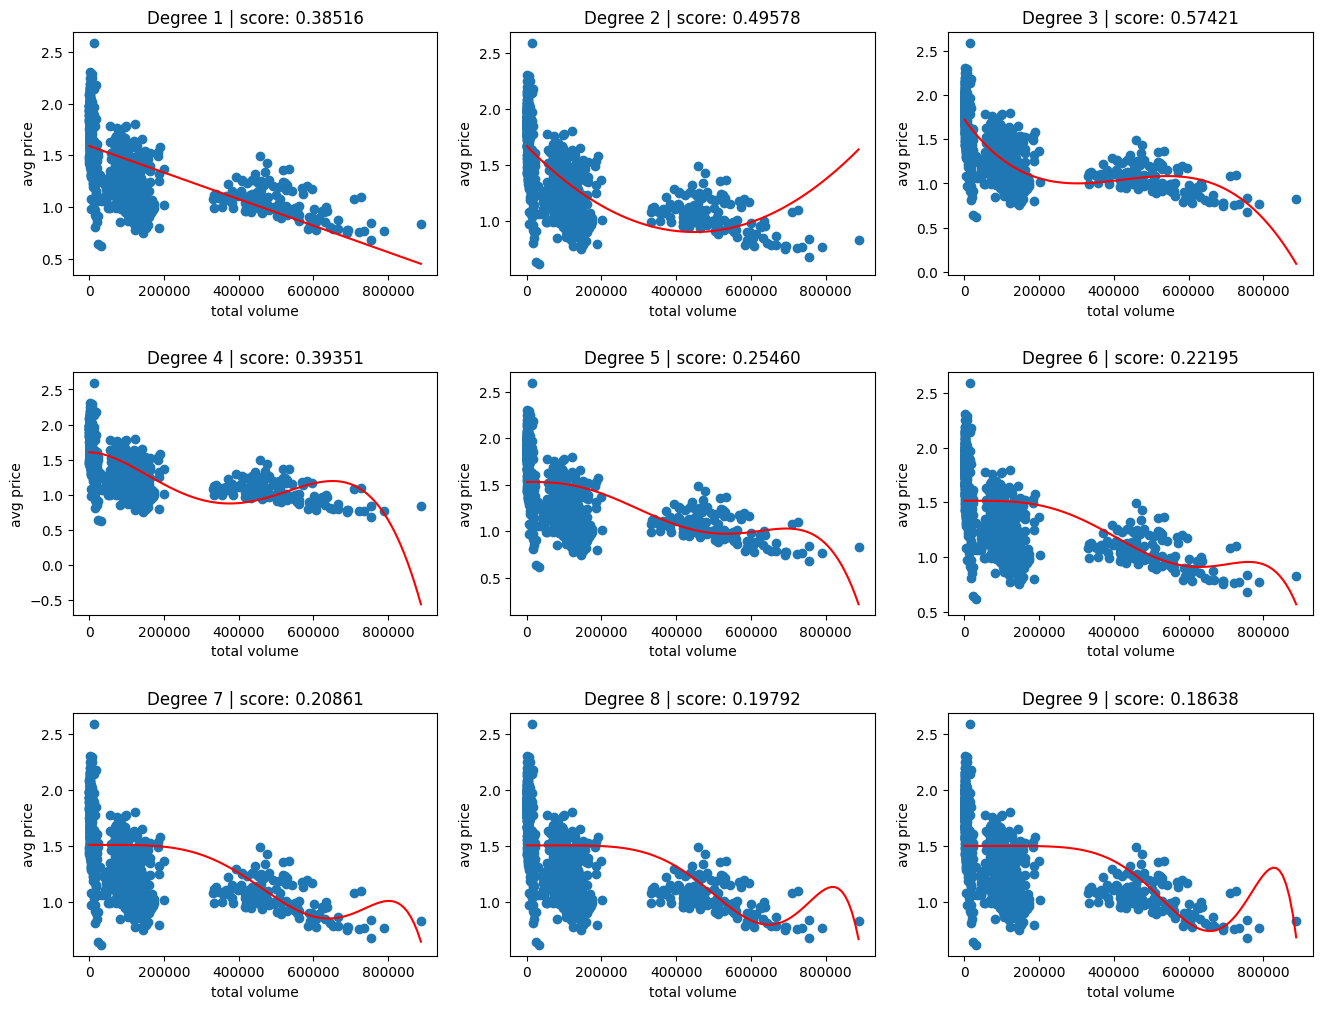

In [106]:
plt.figure(figsize=(16, 12))

test_errors, train_errors, errors = [], [], []
true_y = y[:split_on]

for order in range(1, 10):

    poly = PolynomialFeatures(order, include_bias=False)
    X_order = poly.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_order, y, test_size=0.3, random_state=44)

    poly_reg_model = LinearRegression()
    pred_y = poly_reg_model.fit(X_order, y).predict(X_order)

    test = poly_reg_model.predict(X_test)
    train = poly_reg_model.predict(X_train)
    test_errors.append(mean_squared_error(y_test, test))
    train_errors.append(mean_squared_error(y_train, train))

    plt.subplot(3, 3, order)
    plt.subplots_adjust(hspace=0.4)

    plt.scatter(X, y)
    x = np.argsort(X.ravel())
    X_reshaped = X.reshape(-1)
    model_poly = np.poly1d(np.polyfit(X_reshaped[x], pred_y[x], order))
    space = np.linspace(min(X), max(X), 100)
    plt.plot(space, model_poly(space), color='r')
    plt.title(f'Degree {order} | score: {poly_reg_model.score(X_order, y):.5f}')
    plt.xlabel('total volume')
    plt.ylabel('avg price')

plt.show()

# Note:
    As we can see the regression can be further improved by using polynomials.

    The best polynomial found (when it comes to score was a 3rd degree one)
    
    The two crucial points in the dataset are: 
- the point where the volume reaches 800 000 - theres a big gap between the next datapoint - making the higher degree plots worse candidate for the best regression
-  a gap between the 200 000 and 400 000 volume

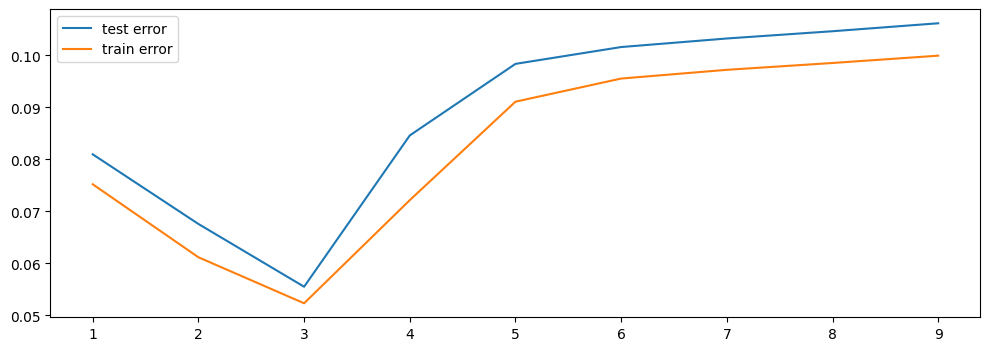

In [107]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(1, 10), test_errors, label='test error')
plt.plot(np.arange(1, 10), train_errors, label='train error')
plt.legend()
plt.show()

# Note:
    We can see a quick decrease in the test and train error on the first models and a sudden increase when the polynomial hits a 4rd degree.
    
    The 3rd degree polynomial is the perfect candidate for our model - it achieves the lowest train and test errors.

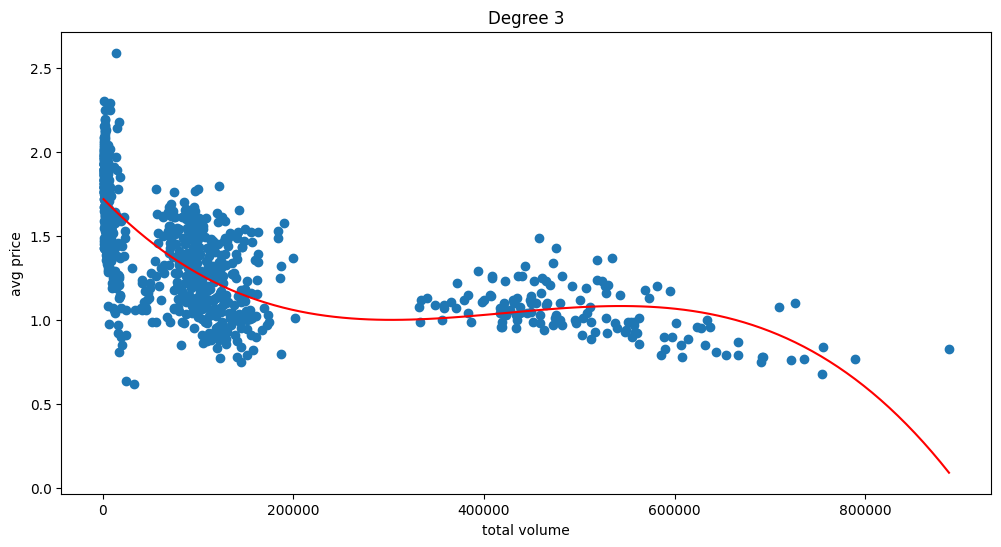

Mean squared error equals: 0.05328
Square root of the mean squared error equals: 0.23083
Model score: 0.38516


In [108]:
plt.figure(figsize=(12, 6))

order = 3

poly = PolynomialFeatures(order, include_bias=False)
X3 = poly.fit_transform(X)

poly_reg_model = LinearRegression()
pred_y = poly_reg_model.fit(X3, y).predict(X3)

plt.scatter(X, y)
x = np.argsort(X.ravel())
X_reshaped = X.reshape(-1)
model_poly = np.poly1d(np.polyfit(X_reshaped[x], pred_y[x], order))
space = np.linspace(min(X), max(X), 100)
plt.plot(space, model_poly(space), color='r')
plt.title(f'Degree {order}')
plt.xlabel('total volume')
plt.ylabel('avg price')
plt.show()

print(f'Mean squared error equals: {mean_squared_error(y, pred_y):.5f}')
print(f'Square root of the mean squared error equals: {np.sqrt(mean_squared_error(y, pred_y)):.5f}')
print(f'Model score: {model.score(X, y):.5f}')

# Note:
    As we can see our best candidate has a major flaw - the slope after 600 000 mark starts to be to steep - meaning that it the idea of predicting prices of the avocados with the total volume above 800 000 can be very misleading when using such model.
    
    On the other hand the model would nicely predict the values in the middle of the dataset - where we have the gap (so the points between 200 000 and 400 000 volume)

Mean squared error equals: 16606080749.32574
Square root of the mean squared error equals: 128864.58299
Model score: 0.42989


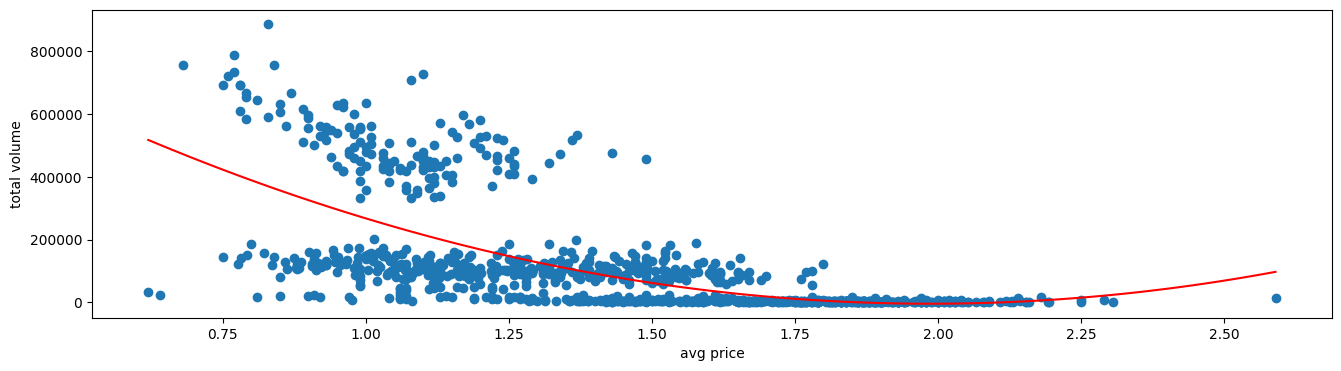

In [109]:
X = avocado_df.AveragePrice.values.reshape(-1, 1)[:split_on]
y = avocado_df.TotalVolume.values.reshape(-1)[:split_on]

plt.figure(figsize=(16, 4))

order = 2

poly = PolynomialFeatures(order, include_bias=False)
X_order = poly.fit_transform(X)

model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)
fit = model.fit(X_order, y)
pred_y = fit.predict(X_order)

plt.scatter(X, y)

x = np.argsort(X.ravel())
X_reshaped = X.reshape(-1)
model_poly = np.poly1d(np.polyfit(X_reshaped[x], pred_y[x], order))
space = np.linspace(min(X), max(X), 100)
plt.plot(space, model_poly(space), color='r')

plt.xlabel('avg price')
plt.ylabel('total volume')

print(f'Mean squared error equals: {mean_squared_error(y, pred_y):.5f}')
print(f'Square root of the mean squared error equals: {np.sqrt(mean_squared_error(y, pred_y)):.5f}')
print(f'Model score: {model.score(X_order, y):.5f}')

# Note:
    Lastly I've wanted to make a regression model for the average price to total volume.

    I chose the 2nd degree polynomial - as it achieved a good score (comparing to the other ones) and when comparing to the previous model (total volume to average price) it achieved a better one - meaning that predicting the total volume based on the average price would be better.